In [1]:
import os
import time
import re
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)

import seaborn as sns
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.notebook import tqdm

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

random_state = 12345

## I. Task review

### **Short intro**

There are esports competitions on the game Counter-Strike: Global Offensive of various major/minor levels and friendly matches with a certain frequency in the world. Famous teams play for the title of champions and cash prizes as well as these events focus the attention of millions of players around the world.

### **Main goal**
1. We need to build a predictive model that answers the question: “will the chosen team win on the map and with what probability?” using the provided team statistics.

### **Work stages**
We need to:
1. Open and research files with data.
2. Find out what features have the importance on out target event - iwn in the map. Create additional features from provided data as it's possble for achiving best result on ML.
3. Prepare datas for further training for machine learning models.
4. Train ML models and find the best one with maximum of accuracy rate AUC-ROC. 
5. Check the accuracy of chosen model using test data (file from provided data).
6. Summarize the analysis and select the best model to predict winner.

### **Additional information**

* The partial data uploaded from early 2022 to mid-summer 2022.
* The sample contains matches played at S-tournaments (tournaments of the highest level) during this period.

## II. Overview and data processing

### 1. Initial review

First, let's make a profile about the received initial data.

In [2]:
train = pd.read_csv('~/Desktop/Py_projects/GitHub/Test_tasks/Win_predict_cs/datasets/train.csv')
test = pd.read_csv('~/Desktop/Py_projects/GitHub/Test_tasks/Win_predict_cs/datasets/test.csv', 
                   index_col = 'index').reset_index(drop = True)
players_feats = pd.read_csv('~/Desktop/Py_projects/GitHub/Test_tasks/Win_predict_cs/datasets/players_feats.csv')

In [3]:
data_dict = {'train':train, 'test':test, 'players_feats':players_feats}

We will immediately bring the names of the signs to a single style

In [4]:
for df_name, data in data_dict.items():
    data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in data.columns]
    data.rename(columns={'pclass': 'p_class'}, inplace=True)
    print('\n\t\033[4m\033[1m\033[31m{}\033[0m'.format(df_name)) 
    display(data.head())
    print('_' * 135)


	train


,map_id,team1_id,team2_id,map_name,who_win
0,289,6665,7718,Ancient,0
1,715,4411,10577,Inferno,0
2,157,11251,9455,Nuke,1
3,524,4608,7532,Mirage,0
4,404,8637,6667,Overpass,1


_______________________________________________________________________________________________________________________________________

	test


,map_id,team1_id,team2_id,map_name
0,309,5973,5752,Dust2
1,541,5973,5752,Vertigo
2,1,8297,7020,Nuke
3,392,8297,7020,Mirage
4,684,8297,7020,Overpass


_______________________________________________________________________________________________________________________________________

	players_feats


,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,p1_assists_per_round,p1_deaths_per_round,p1_saved_by_teammate_per_round,p1_saved_teammates_per_round,p1_rating,p1_kill_death,p1_kill_round,p1_rounds_with_kills,p1_kill_death_difference,p1_total_opening_kills,p1_total_opening_deaths,p1_opening_kill_ratio,p1_opening_kill_rating,p1_team_win_percent_after_first_kill,p1_first_kill_in_won_rounds,p2_id,p2_total_kills,p2_headshots,p2_total_deaths,p2_kd_ratio,p2_damage_per_round,p2_grenade_damage_per_round,p2_maps_played,p2_rounds_played,p2_kills_per_round,p2_assists_per_round,p2_deaths_per_round,p2_saved_by_teammate_per_round,p2_saved_teammates_per_round,p2_rating,p2_kill_death,p2_kill_round,p2_rounds_with_kills,p2_kill_death_difference,p2_total_opening_kills,p2_total_opening_deaths,p2_opening_kill_ratio,p2_opening_kill_rating,p2_team_win_percent_after_first_kill,p2_first_kill_in_won_rounds,p3_id,p3_total_kills,p3_headshots,p3_total_deaths,p3_kd_ratio,p3_damage_per_round,p3_grenade_damage_per_round,p3_maps_played,p3_rounds_played,p3_kills_per_round,p3_assists_per_round,p3_deaths_per_round,p3_saved_by_teammate_per_round,p3_saved_teammates_per_round,p3_rating,p3_kill_death,p3_kill_round,p3_rounds_with_kills,p3_kill_death_difference,p3_total_opening_kills,p3_total_opening_deaths,p3_opening_kill_ratio,p3_opening_kill_rating,p3_team_win_percent_after_first_kill,p3_first_kill_in_won_rounds,p4_id,p4_total_kills,p4_headshots,p4_total_deaths,p4_kd_ratio,p4_damage_per_round,p4_grenade_damage_per_round,p4_maps_played,p4_rounds_played,p4_kills_per_round,p4_assists_per_round,p4_deaths_per_round,p4_saved_by_teammate_per_round,p4_saved_teammates_per_round,p4_rating,p4_kill_death,p4_kill_round,p4_rounds_with_kills,p4_kill_death_difference,p4_total_opening_kills,p4_total_opening_deaths,p4_opening_kill_ratio,p4_opening_kill_rating,p4_team_win_percent_after_first_kill,p4_first_kill_in_won_rounds,p5_id,p5_total_kills,p5_headshots,p5_total_deaths,p5_kd_ratio,p5_damage_per_round,p5_grenade_damage_per_round,p5_maps_played,p5_rounds_played,p5_kills_per_round,p5_assists_per_round,p5_deaths_per_round,p5_saved_by_teammate_per_round,p5_saved_teammates_per_round,p5_rating,p5_kill_death,p5_kill_round,p5_rounds_with_kills,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name,map_id
0,4954,90,42.2,112,0.80,76.3,5.9,6,156,0.58,0.24,0.72,0.13,0.05,0.98,0.80,0.58,62,-22,10,13,0.77,0.85,60.0,8.2,7412,106,35.8,119,0.89,66.8,5.6,7,181,0.59,0.09,0.66,0.07,0.06,0.91,0.89,0.59,75,-13,17,27,0.63,0.89,82.4,15.4,9078,46,65.2,54,0.85,76.9,4.5,3,75,0.61,0.16,0.72,0.07,0.07,0.93,0.85,0.61,34,-8,4,14,0.29,0.62,50.0,5.0,13843,110,40.9,139,0.79,53.8,3.0,8,204,0.54,0.06,0.68,0.06,0.09,0.83,0.79,0.54,80,-29,15,20,0.75,0.87,53.3,8.2,15165,140,40.7,133,1.05,83.9,9.2,8,198,0.71,0.17,0.67,0.07,0.07,1.16,1.04,0.70,84,5,25,12,2.08,1.28,84.0,25.0,6665,Ancient,635
1,5794,45,60.0,57,0.79,82.3,10.9,3,68,0.66,0.15,0.84,0.07,0.07,0.90,0.79,0.66,30,-12,5,10,0.50,0.79,40.0,10.0,5796,34,50.0,51,0.67,59.0,4.7,3,68,0.50,0.10,0.75,0.04,0.07,0.71,0.67,0.50,27,-17,5,4,1.25,0.94,0.0,0.0,7266,38,42.1,51,0.75,61.0,2.3,3,68,0.56,0.07,0.75,0.03,0.06,0.74,0.75,0.56,25,-13,6,8,0.75,0.91,83.3,25.0,12781,27,33.3,53,0.51,50.4,5.3,3,68,0.40,0.04,0.78,0.01,0.03,0.56,0.51,0.40,22,-26,7,13,0.54,0.86,57.1,20.0,14932,504,55.0,370,1.36,85.8,3.9,23,599,0.84,0.12,0.62,0.08,0.12,1.28,1.36,0.86,233,96,54,34,1.59,1.17,70.4,16.7,7532,Ancient,635
2,4954,156,51.9,167,0.93,63.5,3.4,10,265,0.59,0.10,0.63,0.11,0.11,0.95,0.93,0.59,107,-11,21,18,1.17,0.95,81.0,13.1,7412,125,35.2,135,0.93,68.7,5.7,8,211,0.59,0.13,0.64,0.07,0.07,0.98,0.93,0.59,91,-10,29,25,1.16,1.16,69.0,20.0,9078,73,50.7,79,0.92,72.0,1.2,4,109,0.67,0.12,0.72,0.13,0.06,0.98,0.92,0.67,43,-6,14,21,0.67,0.99,50.0,13.0,138

_______________________________________________________________________________________________________________________________________


And get a general information

In [5]:
for df_name, data in data_dict.items():
    print('\n\t\033[4m\033[1m\033[31m{}\033[0m'.format(df_name)) 
    data.info()
    print()
    display(data.describe())
    print()
    print('\n\t\033[4m\033[1m\033[31m{}\033[0m'.format('Total numbers of missing values:'))
    display(data.isna().sum())
    print('_' * 55)


	train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   map_id    713 non-null    int64 
 1   team1_id  713 non-null    int64 
 2   team2_id  713 non-null    int64 
 3   map_name  713 non-null    object
 4   who_win   713 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 28.0+ KB



,map_id,team1_id,team2_id,who_win
count,713.000000,713.000000,713.000000,713.000000
mean,370.925666,7243.643759,7787.844320,0.458626
std,214.994673,2192.674445,2318.184057,0.498635
min,0.000000,4411.000000,4411.000000,0.000000
25%,184.000000,5005.000000,5973.000000,0.000000
50%,371.000000,6667.000000,7532.000000,0.000000
75%,557.000000,9215.000000,9565.000000,1.000000
max,742.000000,11726.000000,11726.000000,1.000000




	Total numbers of missing values:


map_id      0
team1_id    0
team2_id    0
map_name    0
who_win     0
dtype: int64

_______________________________________________________

	test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   map_id    30 non-null     int64 
 1   team1_id  30 non-null     int64 
 2   team2_id  30 non-null     int64 
 3   map_name  30 non-null     object
dtypes: int64(3), object(1)
memory usage: 1.1+ KB



,map_id,team1_id,team2_id
count,30.000000,30.000000,30.000000
mean,372.766667,5721.500000,6629.800000
std,209.293176,1403.423542,1009.559528
min,1.000000,4494.000000,4411.000000
25%,217.000000,4608.000000,6146.000000
50%,374.500000,4608.000000,6667.000000
75%,535.250000,6666.500000,7020.000000
max,684.000000,8297.000000,8297.000000




	Total numbers of missing values:


map_id      0
team1_id    0
team2_id    0
map_name    0
dtype: int64

_______________________________________________________

	players_feats
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486 entries, 0 to 1485
Columns: 128 entries, p1_id to map_id
dtypes: float64(80), int64(47), object(1)
memory usage: 1.5+ MB



,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,p1_assists_per_round,p1_deaths_per_round,p1_saved_by_teammate_per_round,p1_saved_teammates_per_round,p1_rating,p1_kill_death,p1_kill_round,p1_rounds_with_kills,p1_kill_death_difference,p1_total_opening_kills,p1_total_opening_deaths,p1_opening_kill_ratio,p1_opening_kill_rating,p1_team_win_percent_after_first_kill,p1_first_kill_in_won_rounds,p2_id,p2_total_kills,p2_headshots,p2_total_deaths,p2_kd_ratio,p2_damage_per_round,p2_grenade_damage_per_round,p2_maps_played,p2_rounds_played,p2_kills_per_round,p2_assists_per_round,p2_deaths_per_round,p2_saved_by_teammate_per_round,p2_saved_teammates_per_round,p2_rating,p2_kill_death,p2_kill_round,p2_rounds_with_kills,p2_kill_death_difference,p2_total_opening_kills,p2_total_opening_deaths,p2_opening_kill_ratio,p2_opening_kill_rating,p2_team_win_percent_after_first_kill,p2_first_kill_in_won_rounds,p3_id,p3_total_kills,p3_headshots,p3_total_deaths,p3_kd_ratio,p3_damage_per_round,p3_grenade_damage_per_round,p3_maps_played,p3_rounds_played,p3_kills_per_round,p3_assists_per_round,p3_deaths_per_round,p3_saved_by_teammate_per_round,p3_saved_teammates_per_round,p3_rating,p3_kill_death,p3_kill_round,p3_rounds_with_kills,p3_kill_death_difference,p3_total_opening_kills,p3_total_opening_deaths,p3_opening_kill_ratio,p3_opening_kill_rating,p3_team_win_percent_after_first_kill,p3_first_kill_in_won_rounds,p4_id,p4_total_kills,p4_headshots,p4_total_deaths,p4_kd_ratio,p4_damage_per_round,p4_grenade_damage_per_round,p4_maps_played,p4_rounds_played,p4_kills_per_round,p4_assists_per_round,p4_deaths_per_round,p4_saved_by_teammate_per_round,p4_saved_teammates_per_round,p4_rating,p4_kill_death,p4_kill_round,p4_rounds_with_kills,p4_kill_death_difference,p4_total_opening_kills,p4_total_opening_deaths,p4_opening_kill_ratio,p4_opening_kill_rating,p4_team_win_percent_after_first_kill,p4_first_kill_in_won_rounds,p5_id,p5_total_kills,p5_headshots,p5_total_deaths,p5_kd_ratio,p5_damage_per_round,p5_grenade_damage_per_round,p5_maps_played,p5_rounds_played,p5_kills_per_round,p5_assists_per_round,p5_deaths_per_round,p5_saved_by_teammate_per_round,p5_saved_teammates_per_round,p5_rating,p5_kill_death,p5_kill_round,p5_rounds_with_kills,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_id
count,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1483.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1483.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.00000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1482.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1482.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,



	Total numbers of missing values:


p1_id                                   0
p1_total_kills                          0
p1_headshots                            0
p1_total_deaths                         0
p1_kd_ratio                             0
                                       ..
p5_team_win_percent_after_first_kill    4
p5_first_kill_in_won_rounds             0
team_id                                 0
map_name                                0
map_id                                  0
Length: 128, dtype: int64

_______________________________________________________


In [6]:
print('Duplicates in \033[4m\033[1m\033[31m{}\033[0m:'.format('players_feats.csv'), players_feats.duplicated().sum())
print('-' * 40)

Duplicates in players_feats.csv: 0
----------------------------------------


In [7]:
players_feats.head()

,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,p1_assists_per_round,p1_deaths_per_round,p1_saved_by_teammate_per_round,p1_saved_teammates_per_round,p1_rating,p1_kill_death,p1_kill_round,p1_rounds_with_kills,p1_kill_death_difference,p1_total_opening_kills,p1_total_opening_deaths,p1_opening_kill_ratio,p1_opening_kill_rating,p1_team_win_percent_after_first_kill,p1_first_kill_in_won_rounds,p2_id,p2_total_kills,p2_headshots,p2_total_deaths,p2_kd_ratio,p2_damage_per_round,p2_grenade_damage_per_round,p2_maps_played,p2_rounds_played,p2_kills_per_round,p2_assists_per_round,p2_deaths_per_round,p2_saved_by_teammate_per_round,p2_saved_teammates_per_round,p2_rating,p2_kill_death,p2_kill_round,p2_rounds_with_kills,p2_kill_death_difference,p2_total_opening_kills,p2_total_opening_deaths,p2_opening_kill_ratio,p2_opening_kill_rating,p2_team_win_percent_after_first_kill,p2_first_kill_in_won_rounds,p3_id,p3_total_kills,p3_headshots,p3_total_deaths,p3_kd_ratio,p3_damage_per_round,p3_grenade_damage_per_round,p3_maps_played,p3_rounds_played,p3_kills_per_round,p3_assists_per_round,p3_deaths_per_round,p3_saved_by_teammate_per_round,p3_saved_teammates_per_round,p3_rating,p3_kill_death,p3_kill_round,p3_rounds_with_kills,p3_kill_death_difference,p3_total_opening_kills,p3_total_opening_deaths,p3_opening_kill_ratio,p3_opening_kill_rating,p3_team_win_percent_after_first_kill,p3_first_kill_in_won_rounds,p4_id,p4_total_kills,p4_headshots,p4_total_deaths,p4_kd_ratio,p4_damage_per_round,p4_grenade_damage_per_round,p4_maps_played,p4_rounds_played,p4_kills_per_round,p4_assists_per_round,p4_deaths_per_round,p4_saved_by_teammate_per_round,p4_saved_teammates_per_round,p4_rating,p4_kill_death,p4_kill_round,p4_rounds_with_kills,p4_kill_death_difference,p4_total_opening_kills,p4_total_opening_deaths,p4_opening_kill_ratio,p4_opening_kill_rating,p4_team_win_percent_after_first_kill,p4_first_kill_in_won_rounds,p5_id,p5_total_kills,p5_headshots,p5_total_deaths,p5_kd_ratio,p5_damage_per_round,p5_grenade_damage_per_round,p5_maps_played,p5_rounds_played,p5_kills_per_round,p5_assists_per_round,p5_deaths_per_round,p5_saved_by_teammate_per_round,p5_saved_teammates_per_round,p5_rating,p5_kill_death,p5_kill_round,p5_rounds_with_kills,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name,map_id
0,4954,90,42.2,112,0.80,76.3,5.9,6,156,0.58,0.24,0.72,0.13,0.05,0.98,0.80,0.58,62,-22,10,13,0.77,0.85,60.0,8.2,7412,106,35.8,119,0.89,66.8,5.6,7,181,0.59,0.09,0.66,0.07,0.06,0.91,0.89,0.59,75,-13,17,27,0.63,0.89,82.4,15.4,9078,46,65.2,54,0.85,76.9,4.5,3,75,0.61,0.16,0.72,0.07,0.07,0.93,0.85,0.61,34,-8,4,14,0.29,0.62,50.0,5.0,13843,110,40.9,139,0.79,53.8,3.0,8,204,0.54,0.06,0.68,0.06,0.09,0.83,0.79,0.54,80,-29,15,20,0.75,0.87,53.3,8.2,15165,140,40.7,133,1.05,83.9,9.2,8,198,0.71,0.17,0.67,0.07,0.07,1.16,1.04,0.70,84,5,25,12,2.08,1.28,84.0,25.0,6665,Ancient,635
1,5794,45,60.0,57,0.79,82.3,10.9,3,68,0.66,0.15,0.84,0.07,0.07,0.90,0.79,0.66,30,-12,5,10,0.50,0.79,40.0,10.0,5796,34,50.0,51,0.67,59.0,4.7,3,68,0.50,0.10,0.75,0.04,0.07,0.71,0.67,0.50,27,-17,5,4,1.25,0.94,0.0,0.0,7266,38,42.1,51,0.75,61.0,2.3,3,68,0.56,0.07,0.75,0.03,0.06,0.74,0.75,0.56,25,-13,6,8,0.75,0.91,83.3,25.0,12781,27,33.3,53,0.51,50.4,5.3,3,68,0.40,0.04,0.78,0.01,0.03,0.56,0.51,0.40,22,-26,7,13,0.54,0.86,57.1,20.0,14932,504,55.0,370,1.36,85.8,3.9,23,599,0.84,0.12,0.62,0.08,0.12,1.28,1.36,0.86,233,96,54,34,1.59,1.17,70.4,16.7,7532,Ancient,635
2,4954,156,51.9,167,0.93,63.5,3.4,10,265,0.59,0.10,0.63,0.11,0.11,0.95,0.93,0.59,107,-11,21,18,1.17,0.95,81.0,13.1,7412,125,35.2,135,0.93,68.7,5.7,8,211,0.59,0.13,0.64,0.07,0.07,0.98,0.93,0.59,91,-10,29,25,1.16,1.16,69.0,20.0,9078,73,50.7,79,0.92,72.0,1.2,4,109,0.67,0.12,0.72,0.13,0.06,0.98,0.92,0.67,43,-6,14,21,0.67,0.99,50.0,13.0,138

In total we have next information according to provided data: 
    
**1. Table `train/test` (train/test sample for ML):** 

* `map_id` — unique passenger identifier
* `map_name` - name of the location being played
* `team1_id`— unique team identifier of the first team
* `team2_id` — unique team identifier of the second team
* `who_win` — fact of win, our target feature

**1. Table `players_feats` with additional features of with a detailed analysis of the statistics of each player in the represented team in a certain match:** 

The table shows the signs of players taken from the HLTV website statistics for a six-month period for each `map_id` from the files `train.csv` and `test.csv`. That means that one row is an aggregation for six months of the attributes of the players of the team `team_id` for the map `map_id`. The column names consist of the player's number and the metric name.

for each of 5 players:
* `p?_id` — unique player identifier
* `p?_total_kills` - total number of frags
* `p?_headshots`— total kills to the head
* `p?_total_deaths` — total number of deaths
* `p?_kd_ratio` — the ratio of kills to deaths
* `p?_damage_per_round` — the amount of damage inflicted on the enemy per round
* `p?_grenade_damage_per_round` — the amount of damage by grenades inflicted on the enemy per round
* `p?_maps_played` — number of maps played in the current team
* `p?_kills_per_round` — the ratio of kills per round
* `p?_assists_per_round` — the assists of kills per round
* `p?_deaths_per_round` — the ratio of deaths per round
* `p?_saved_by_teammate_per_round` — the ratio of survival after a meeting with an opponent with the help of a teammate per round
* `p?_saved_teammates_per_round` — the ratio of saving a teammate per round
* `p?_rating` — any type of rating
* `p?_kill_death` — **the same feature with `p?_kd_ratio`**
* `p?_kill_round` — **the same feature with `p?_kills_per_round`**
* `p?_rounds_with_kills` — total numbers of rounds with at least 1 frag
* `p?_kill_death_difference` — delta between total_kills and total_deaths
* `p?_total_opening_kills` — total numbers of rounds with at the first kill in team
* `p?_total_opening_deaths` — total numbers of rounds with at the first death in team
* `p?_opening_kill_ratio` — the ratio of the first kill of this player
* `p?_opening_kill_rating` — the rating of the first kill of this player
* `p?_team_win_percent_after_first_kill` — the probability of winning the round after the first kill by this player
* `p?_first_kill_in_won_rounds` — percentage of completion of the first kill in the won round

Types of value in columns are — integers `int` and real numbers `float` и strings `object`.

We also see in the first view:
- there are some duplicate features in statistic sample of additional features;
- no missing values in rows;
- no duplicate rows in statistic sample of additional features.

In [8]:
players_feats.isna().sum()

p1_id                                   0
p1_total_kills                          0
p1_headshots                            0
p1_total_deaths                         0
p1_kd_ratio                             0
                                       ..
p5_team_win_percent_after_first_kill    4
p5_first_kill_in_won_rounds             0
team_id                                 0
map_name                                0
map_id                                  0
Length: 128, dtype: int64

In [9]:
players_feats = players_feats.dropna()

### 2. Player's profile

Let's create statistics for each player. This can be useful if there is a time markup in the provided sample. Then it will be possible to solve the prediction problem through time series predicting the results of each player's game based on his previously played matches.

In [10]:
def create_player_statistic(data):

    
    def cutting(data, number, rows=1):
        data = data.head(rows)
        match_info = data.loc[:, 'team_id':'map_id'].head(rows)
        cutted_data = (pd.concat([data.filter(like='p'+str(number)),
                                  match_info],
                                 sort=False,
                                 axis=1)
                      ).rename(
            columns=lambda col: col.replace("p"+str(number)+"_", "")
        )
        return cutted_data
    
    
    def adding_to_head(data1, data2):
        new_data = (pd.concat([data1,
                               data2],
                              sort=False,
                              axis=0))
        return new_data
    
    
    head = cutting(data, 1, 0)
    
    
    for i in tqdm(range(len(data.index))):
        current_team = data[data.index==i]
        for player in range(1,6): 
            player_statistic = cutting(current_team, player)
            
            if player == 1:
                players_statistic_in_team = adding_to_head(head, player_statistic)
            else:
                players_statistic_in_team = adding_to_head(players_statistic_in_team, player_statistic)
            
        if i == 0:
            players_statistic = adding_to_head(head, players_statistic_in_team)
        else:
            players_statistic = adding_to_head(players_statistic, players_statistic_in_team)
    
    players_statistic = players_statistic.reset_index(drop=True)

    return players_statistic

In [11]:
players_statistic = create_player_statistic(players_feats)

  0%|          | 0/1470 [00:00<?, ?it/s]

In [12]:
players_statistic = players_statistic.sort_values(
    by=['id', 'total_kills', 'total_deaths'], ascending=True).reset_index(drop=True)

players_statistic.head(10)

,id,total_kills,headshots,total_deaths,kd_ratio,damage_per_round,grenade_damage_per_round,maps_played,rounds_played,kills_per_round,assists_per_round,deaths_per_round,saved_by_teammate_per_round,saved_teammates_per_round,rating,kill_death,kill_round,rounds_with_kills,kill_death_difference,total_opening_kills,total_opening_deaths,opening_kill_ratio,opening_kill_rating,team_win_percent_after_first_kill,first_kill_in_won_rounds,team_id,map_name,map_id
0,29,294,62.6,281,1.05,69.0,2.6,17,449,0.65,0.11,0.63,0.12,0.10,1.03,1.04,0.65,163,10,24,22,1.09,0.90,58.3,7.5,5422,Inferno,531
1,29,315,62.9,295,1.07,70.5,2.6,18,473,0.67,0.11,0.62,0.12,0.10,1.05,1.07,0.66,177,17,26,22,1.18,0.91,57.7,7.4,5422,Inferno,245
2,29,318,57.2,296,1.07,74.9,5.3,17,462,0.69,0.14,0.64,0.08,0.08,1.09,1.06,0.68,194,15,35,28,1.25,0.98,82.9,13.6,5422,Vertigo,142
3,29,318,57.2,296,1.07,74.9,5.3,17,462,0.69,0.14,0.64,0.08,0.08,1.09,1.06,0.68,194,15,35,28,1.25,0.98,82.9,13.6,5422,Vertigo,666
4,29,339,51.6,329,1.03,76.0,2.0,18,480,0.71,0.14,0.69,0.09,0.13,1.04,1.01,0.71,162,2,29,31,0.94,0.94,75.9,12.8,5422,Overpass,707
5,29,367,55.3,345,1.06,74.5,5.5,19,526,0.70,0.13,0.66,0.08,0.10,1.08,1.05,0.69,226,15,43,33,1.30,1.01,72.1,12.9,5422,Vertigo,394
6,29,484,58.5,492,0.98,69.6,3.6,26,753,0.64,0.10,0.65,0.09,0.09,0.99,0.99,0.64,304,-6,60,57,1.05,0.98,65.0,12.5,5422,Mirage,587
7,284,62,72.6,56,1.11,70.8,4.2,4,93,0.67,0.12,0.60,0.05,0.12,1.02,1.11,0.67,46,6,6,8,0.75,0.85,66.7,7.8,5995,Ancient,525
8,284,67,59.7,77,0.87,57.6,1.5,5,127,0.53,0.12,0.61,0.11,0.06,0.90,0.87,0.53,49,-10,9,11,0.82,0.88,77.8,9.6,5995,Ancient,528
9,284,72,65.3,76,0.95,62.2,3.2,5,124,0.58,0.13,0.61,0.09,0.10,0.94,0.95,0.58,53,-4,7,14,0.50,0.76,57.1,5.6,5995,Ancient,668


We found one duplicate when there are no changes in any indicators for different matches, most likely it is due to a technical defeat of one of the teams, I suggest not to take into account these matches, so as not to bring the schedule to a plateau.

In [13]:
indexes_for_del = list(players_statistic[players_statistic.loc[:,:'map_name'].duplicated() == True].index)
len(indexes_for_del)

236

In [14]:
players_statistic = players_statistic.drop(index=indexes_for_del)

In [15]:
columns_for_delta = ['total_kills','total_deaths','rounds_played',
                     'rounds_with_kills','total_opening_kills',
                     'total_opening_deaths']

In [16]:
players_statistic = players_statistic.drop(columns=columns_for_delta)

We will also remove the signs that repeat each other, as noted from the initial acquaintance with the data

In [17]:
players_statistic = players_statistic.drop(columns=['kill_death','kill_round'])

In [18]:
players_statistic.head()

,id,headshots,kd_ratio,damage_per_round,grenade_damage_per_round,maps_played,kills_per_round,assists_per_round,deaths_per_round,saved_by_teammate_per_round,saved_teammates_per_round,rating,kill_death_difference,opening_kill_ratio,opening_kill_rating,team_win_percent_after_first_kill,first_kill_in_won_rounds,team_id,map_name,map_id
0,29,62.6,1.05,69.0,2.6,17,0.65,0.11,0.63,0.12,0.10,1.03,10,1.09,0.90,58.3,7.5,5422,Inferno,531
1,29,62.9,1.07,70.5,2.6,18,0.67,0.11,0.62,0.12,0.10,1.05,17,1.18,0.91,57.7,7.4,5422,Inferno,245
2,29,57.2,1.07,74.9,5.3,17,0.69,0.14,0.64,0.08,0.08,1.09,15,1.25,0.98,82.9,13.6,5422,Vertigo,142
4,29,51.6,1.03,76.0,2.0,18,0.71,0.14,0.69,0.09,0.13,1.04,2,0.94,0.94,75.9,12.8,5422,Overpass,707
5,29,55.3,1.06,74.5,5.5,19,0.70,0.13,0.66,0.08,0.10,1.08,15,1.30,1.01,72.1,12.9,5422,Vertigo,394


So we have a database of features that we can combine with our training sample by team id and match id. Added victory statistics to these profiles

In [19]:
merge1 = players_statistic.merge(train, left_on =["map_id","team_id"], right_on=["map_id","team1_id"], how='inner')
merge2 = players_statistic.merge(train, left_on =["map_id","team_id"], right_on=["map_id","team2_id"], how='inner')

It will be necessary to process the `who_wins` column, as we bring it to each player

In [20]:
def vice_verse(who_win):
    if who_win == 1:
        return 0
    return 1

In [21]:
merge1 = merge1.drop("team2_id", axis=1)
merge1['who_win'] = merge1['who_win'].apply(vice_verse)
merge2 = merge2.drop("team1_id", axis=1)
pass

In [22]:
merge_players_statistic = pd.concat([merge1,merge2],sort=False,axis=0)

In [23]:
merge_players_statistic.loc[
    merge_players_statistic['team1_id'].isna(), 'team1_id'
] = merge_players_statistic.loc[
    merge_players_statistic['team1_id'].isna()]['team2_id']

In [24]:
merge_players_statistic = merge_players_statistic.drop(
    ["team1_id","team2_id","map_name_y"], axis=1).rename(
    columns={"map_name_x":"map_name",
            "who_win":"win"})

We got this result

In [25]:
merge_players_statistic.head()

,id,headshots,kd_ratio,damage_per_round,grenade_damage_per_round,maps_played,kills_per_round,assists_per_round,deaths_per_round,saved_by_teammate_per_round,saved_teammates_per_round,rating,kill_death_difference,opening_kill_ratio,opening_kill_rating,team_win_percent_after_first_kill,first_kill_in_won_rounds,team_id,map_name,map_id,win
0,284,71.1,1.09,70.7,5.5,5,0.65,0.10,0.59,0.05,0.11,1.03,7,1.00,0.88,75.0,9.0,5995,Ancient,391,0
1,3741,51.8,1.24,94.7,5.9,5,0.88,0.13,0.70,0.08,0.13,1.30,22,1.29,1.30,77.3,25.4,5995,Ancient,391,0
2,3972,49.1,1.29,98.4,6.7,5,0.84,0.16,0.66,0.08,0.02,1.28,24,1.80,1.24,66.7,17.9,5995,Ancient,391,0
3,9816,29.1,0.77,62.0,8.1,6,0.50,0.15,0.66,0.12,0.10,0.88,-24,0.76,0.95,81.2,15.7,5995,Ancient,391,0
4,19230,29.2,0.92,53.3,3.1,5,0.56,0.03,0.61,0.05,0.03,0.87,-6,1.38,0.99,63.6,10.4,5995,Ancient,391,0


### 3. Samples joining

Let's combine our samples with the statistics of players by matches

In [26]:
def merge_statistic(data1, statistic):

    for i in tqdm(range(len(data1))):
        map_id = list(data1[data1.index==i]['map_id'])
        merge = (pd
             .merge(data1[data1.index==i], statistic.query('map_id in @map_id'), 
                    left_on = "team1_id", right_on = "team_id")
             .drop(columns=["map_name_y","map_id_y"])
             .merge(statistic.query('map_id == @map_id'), 
                    left_on = "team2_id", right_on = "team_id")
            .drop(columns=["map_name","map_id"])
            )
        if i == 0:
            final = merge
        else:
            final = (pd
                     .concat([final,merge],sort=False,axis=0)
                     .reset_index(drop=True))
    return final

In [27]:
train = (merge_statistic(train, players_feats)
         .rename(columns={"team1_id": "team_x", "team2_id": "team_y"}))
train.head(2)

  0%|          | 0/713 [00:00<?, ?it/s]

,map_id_x,team_x,team_y,map_name_x,who_win,p1_id_x,p1_total_kills_x,p1_headshots_x,p1_total_deaths_x,p1_kd_ratio_x,p1_damage_per_round_x,p1_grenade_damage_per_round_x,p1_maps_played_x,p1_rounds_played_x,p1_kills_per_round_x,p1_assists_per_round_x,p1_deaths_per_round_x,p1_saved_by_teammate_per_round_x,p1_saved_teammates_per_round_x,p1_rating_x,p1_kill_death_x,p1_kill_round_x,p1_rounds_with_kills_x,p1_kill_death_difference_x,p1_total_opening_kills_x,p1_total_opening_deaths_x,p1_opening_kill_ratio_x,p1_opening_kill_rating_x,p1_team_win_percent_after_first_kill_x,p1_first_kill_in_won_rounds_x,p2_id_x,p2_total_kills_x,p2_headshots_x,p2_total_deaths_x,p2_kd_ratio_x,p2_damage_per_round_x,p2_grenade_damage_per_round_x,p2_maps_played_x,p2_rounds_played_x,p2_kills_per_round_x,p2_assists_per_round_x,p2_deaths_per_round_x,p2_saved_by_teammate_per_round_x,p2_saved_teammates_per_round_x,p2_rating_x,p2_kill_death_x,p2_kill_round_x,p2_rounds_with_kills_x,p2_kill_death_difference_x,p2_total_opening_kills_x,p2_total_opening_deaths_x,p2_opening_kill_ratio_x,p2_opening_kill_rating_x,p2_team_win_percent_after_first_kill_x,p2_first_kill_in_won_rounds_x,p3_id_x,p3_total_kills_x,p3_headshots_x,p3_total_deaths_x,p3_kd_ratio_x,p3_damage_per_round_x,p3_grenade_damage_per_round_x,p3_maps_played_x,p3_rounds_played_x,p3_kills_per_round_x,p3_assists_per_round_x,p3_deaths_per_round_x,p3_saved_by_teammate_per_round_x,p3_saved_teammates_per_round_x,p3_rating_x,p3_kill_death_x,p3_kill_round_x,p3_rounds_with_kills_x,p3_kill_death_difference_x,p3_total_opening_kills_x,p3_total_opening_deaths_x,p3_opening_kill_ratio_x,p3_opening_kill_rating_x,p3_team_win_percent_after_first_kill_x,p3_first_kill_in_won_rounds_x,p4_id_x,p4_total_kills_x,p4_headshots_x,p4_total_deaths_x,p4_kd_ratio_x,p4_damage_per_round_x,p4_grenade_damage_per_round_x,p4_maps_played_x,p4_rounds_played_x,p4_kills_per_round_x,p4_assists_per_round_x,p4_deaths_per_round_x,p4_saved_by_teammate_per_round_x,p4_saved_teammates_per_round_x,p4_rating_x,p4_kill_death_x,p4_kill_round_x,p4_rounds_with_kills_x,p4_kill_death_difference_x,p4_total_opening_kills_x,p4_total_opening_deaths_x,p4_opening_kill_ratio_x,p4_opening_kill_rating_x,p4_team_win_percent_after_first_kill_x,p4_first_kill_in_won_rounds_x,p5_id_x,p5_total_kills_x,p5_headshots_x,p5_total_deaths_x,p5_kd_ratio_x,p5_damage_per_round_x,p5_grenade_damage_per_round_x,p5_maps_played_x,p5_rounds_played_x,p5_kills_per_round_x,p5_assists_per_round_x,p5_deaths_per_round_x,p5_saved_by_teammate_per_round_x,p5_saved_teammates_per_round_x,p5_rating_x,p5_kill_death_x,p5_kill_round_x,p5_rounds_with_kills_x,p5_kill_death_difference_x,p5_total_opening_kills_x,p5_total_opening_deaths_x,p5_opening_kill_ratio_x,p5_opening_kill_rating_x,p5_team_win_percent_after_first_kill_x,p5_first_kill_in_won_rounds_x,team_id_x,p1_id_y,p1_total_kills_y,p1_headshots_y,p1_total_deaths_y,p1_kd_ratio_y,p1_damage_per_round_y,p1_grenade_damage_per_round_y,p1_maps_played_y,p1_rounds_played_y,p1_kills_per_round_y,p1_assists_per_round_y,p1_deaths_per_round_y,p1_saved_by_teammate_per_round_y,p1_saved_teammates_per_round_y,p1_rating_y,p1_kill_death_y,p1_kill_round_y,p1_rounds_with_kills_y,p1_kill_death_difference_y,p1_total_opening_kills_y,p1_total_opening_deaths_y,p1_opening_kill_ratio_y,p1_opening_kill_rating_y,p1_team_win_percent_after_first_kill_y,p1_first_kill_in_won_rounds_y,p2_id_y,p2_total_kills_y,p2_headshots_y,p2_total_deaths_y,p2_kd_ratio_y,p2_damage_per_round_y,p2_grenade_damage_per_round_y,p2_maps_played_y,p2_rounds_played_y,p2_kills_per_round_y,p2_assists_per_round_y,p2_deaths_per_round_y,p2_saved_by_teammate_per_round_y,p2_saved_teammates_per_round_y,p2_rating_y,p2_kill_death_y,p2_kill_round_y,p2_rounds_with_kills_y,p2_kill_death_difference_y,p2_total_opening_kills_y,p2_total_opening_deaths_y,p2_opening_kill_ratio_y,p2_opening_kill_rating_y,p2_team_win_percent_after_first_kill_y,p2_first_kill_in_won_rounds_y,p3_id_y,p3_total_kills_y,p3_headshots_y,p3_total_deaths_y,p3_kd_ratio_y,p3_d

In [28]:
test = (merge_statistic(test, players_feats)
         .rename(columns={"team1_id": "team_x", "team2_id": "team_y"}))
test.head(2)

  0%|          | 0/30 [00:00<?, ?it/s]

,map_id_x,team_x,team_y,map_name_x,p1_id_x,p1_total_kills_x,p1_headshots_x,p1_total_deaths_x,p1_kd_ratio_x,p1_damage_per_round_x,p1_grenade_damage_per_round_x,p1_maps_played_x,p1_rounds_played_x,p1_kills_per_round_x,p1_assists_per_round_x,p1_deaths_per_round_x,p1_saved_by_teammate_per_round_x,p1_saved_teammates_per_round_x,p1_rating_x,p1_kill_death_x,p1_kill_round_x,p1_rounds_with_kills_x,p1_kill_death_difference_x,p1_total_opening_kills_x,p1_total_opening_deaths_x,p1_opening_kill_ratio_x,p1_opening_kill_rating_x,p1_team_win_percent_after_first_kill_x,p1_first_kill_in_won_rounds_x,p2_id_x,p2_total_kills_x,p2_headshots_x,p2_total_deaths_x,p2_kd_ratio_x,p2_damage_per_round_x,p2_grenade_damage_per_round_x,p2_maps_played_x,p2_rounds_played_x,p2_kills_per_round_x,p2_assists_per_round_x,p2_deaths_per_round_x,p2_saved_by_teammate_per_round_x,p2_saved_teammates_per_round_x,p2_rating_x,p2_kill_death_x,p2_kill_round_x,p2_rounds_with_kills_x,p2_kill_death_difference_x,p2_total_opening_kills_x,p2_total_opening_deaths_x,p2_opening_kill_ratio_x,p2_opening_kill_rating_x,p2_team_win_percent_after_first_kill_x,p2_first_kill_in_won_rounds_x,p3_id_x,p3_total_kills_x,p3_headshots_x,p3_total_deaths_x,p3_kd_ratio_x,p3_damage_per_round_x,p3_grenade_damage_per_round_x,p3_maps_played_x,p3_rounds_played_x,p3_kills_per_round_x,p3_assists_per_round_x,p3_deaths_per_round_x,p3_saved_by_teammate_per_round_x,p3_saved_teammates_per_round_x,p3_rating_x,p3_kill_death_x,p3_kill_round_x,p3_rounds_with_kills_x,p3_kill_death_difference_x,p3_total_opening_kills_x,p3_total_opening_deaths_x,p3_opening_kill_ratio_x,p3_opening_kill_rating_x,p3_team_win_percent_after_first_kill_x,p3_first_kill_in_won_rounds_x,p4_id_x,p4_total_kills_x,p4_headshots_x,p4_total_deaths_x,p4_kd_ratio_x,p4_damage_per_round_x,p4_grenade_damage_per_round_x,p4_maps_played_x,p4_rounds_played_x,p4_kills_per_round_x,p4_assists_per_round_x,p4_deaths_per_round_x,p4_saved_by_teammate_per_round_x,p4_saved_teammates_per_round_x,p4_rating_x,p4_kill_death_x,p4_kill_round_x,p4_rounds_with_kills_x,p4_kill_death_difference_x,p4_total_opening_kills_x,p4_total_opening_deaths_x,p4_opening_kill_ratio_x,p4_opening_kill_rating_x,p4_team_win_percent_after_first_kill_x,p4_first_kill_in_won_rounds_x,p5_id_x,p5_total_kills_x,p5_headshots_x,p5_total_deaths_x,p5_kd_ratio_x,p5_damage_per_round_x,p5_grenade_damage_per_round_x,p5_maps_played_x,p5_rounds_played_x,p5_kills_per_round_x,p5_assists_per_round_x,p5_deaths_per_round_x,p5_saved_by_teammate_per_round_x,p5_saved_teammates_per_round_x,p5_rating_x,p5_kill_death_x,p5_kill_round_x,p5_rounds_with_kills_x,p5_kill_death_difference_x,p5_total_opening_kills_x,p5_total_opening_deaths_x,p5_opening_kill_ratio_x,p5_opening_kill_rating_x,p5_team_win_percent_after_first_kill_x,p5_first_kill_in_won_rounds_x,team_id_x,p1_id_y,p1_total_kills_y,p1_headshots_y,p1_total_deaths_y,p1_kd_ratio_y,p1_damage_per_round_y,p1_grenade_damage_per_round_y,p1_maps_played_y,p1_rounds_played_y,p1_kills_per_round_y,p1_assists_per_round_y,p1_deaths_per_round_y,p1_saved_by_teammate_per_round_y,p1_saved_teammates_per_round_y,p1_rating_y,p1_kill_death_y,p1_kill_round_y,p1_rounds_with_kills_y,p1_kill_death_difference_y,p1_total_opening_kills_y,p1_total_opening_deaths_y,p1_opening_kill_ratio_y,p1_opening_kill_rating_y,p1_team_win_percent_after_first_kill_y,p1_first_kill_in_won_rounds_y,p2_id_y,p2_total_kills_y,p2_headshots_y,p2_total_deaths_y,p2_kd_ratio_y,p2_damage_per_round_y,p2_grenade_damage_per_round_y,p2_maps_played_y,p2_rounds_played_y,p2_kills_per_round_y,p2_assists_per_round_y,p2_deaths_per_round_y,p2_saved_by_teammate_per_round_y,p2_saved_teammates_per_round_y,p2_rating_y,p2_kill_death_y,p2_kill_round_y,p2_rounds_with_kills_y,p2_kill_death_difference_y,p2_total_opening_kills_y,p2_total_opening_deaths_y,p2_opening_kill_ratio_y,p2_opening_kill_rating_y,p2_team_win_percent_after_first_kill_y,p2_first_kill_in_won_rounds_y,p3_id_y,p3_total_kills_y,p3_headshots_y,p3_total_deaths_y,p3_kd_ratio_y,p3_damage_pe

In [29]:
for sample_name, sample in {'train':train, 'test':test}.items():
    print('Duplicates in \033[4m\033[1m\033[31m{}\033[0m:'.format(sample_name), sample.duplicated().sum())
    print('-' * 40)

Duplicates in train: 0
----------------------------------------
Duplicates in test: 0
----------------------------------------


### 4. Encoding features

In [30]:
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(train[
    ['map_name_x']
]), columns=['map_name_label'])

encoder.categories_

[array(['Ancient', 'Dust2', 'Inferno', 'Mirage', 'Nuke', 'Overpass',
        'Vertigo'], dtype=object)]

Markers are assigned accordingly:

- map_name : 'Ancient' = 0, 'Dust2' = 1, 'Inferno' = 2, 'Mirage' = 3, 'Nuke' = 4, 'Overpass' = 5, 'Vertigo' = 6

Remove unnecessary signs

In [31]:
columns_for_del = train.filter(
    regex='map_name_x|kill_death|kill_round|_id|total_kills')

columns_for_del = train.filter(
    regex='map_name_x|kill_death|kill_round|_id|total_kills|total_deaths|rounds_played|rounds_with_kills|total_opening_kills|total_opening_deaths')

In [32]:
train = pd.concat([train,df_ordinal],sort=False,axis=1).drop(columns=columns_for_del)

And for test sample

In [33]:
encoder = OrdinalEncoder()
test_ordinal = pd.DataFrame(encoder.fit_transform(test[
    ['map_name_x']
]), columns=['map_name_label'])

encoder.categories_

[array(['Ancient', 'Dust2', 'Inferno', 'Mirage', 'Nuke', 'Overpass',
        'Vertigo'], dtype=object)]

In [34]:
test = pd.concat([test,test_ordinal],sort=False,axis=1).drop(columns=columns_for_del)

In [35]:
train.head()

,team_x,team_y,who_win,p1_headshots_x,p1_total_deaths_x,p1_kd_ratio_x,p1_damage_per_round_x,p1_grenade_damage_per_round_x,p1_maps_played_x,p1_rounds_played_x,p1_kills_per_round_x,p1_assists_per_round_x,p1_deaths_per_round_x,p1_saved_by_teammate_per_round_x,p1_saved_teammates_per_round_x,p1_rating_x,p1_rounds_with_kills_x,p1_total_opening_kills_x,p1_total_opening_deaths_x,p1_opening_kill_ratio_x,p1_opening_kill_rating_x,p1_team_win_percent_after_first_kill_x,p1_first_kill_in_won_rounds_x,p2_headshots_x,p2_total_deaths_x,p2_kd_ratio_x,p2_damage_per_round_x,p2_grenade_damage_per_round_x,p2_maps_played_x,p2_rounds_played_x,p2_kills_per_round_x,p2_assists_per_round_x,p2_deaths_per_round_x,p2_saved_by_teammate_per_round_x,p2_saved_teammates_per_round_x,p2_rating_x,p2_rounds_with_kills_x,p2_total_opening_kills_x,p2_total_opening_deaths_x,p2_opening_kill_ratio_x,p2_opening_kill_rating_x,p2_team_win_percent_after_first_kill_x,p2_first_kill_in_won_rounds_x,p3_headshots_x,p3_total_deaths_x,p3_kd_ratio_x,p3_damage_per_round_x,p3_grenade_damage_per_round_x,p3_maps_played_x,p3_rounds_played_x,p3_kills_per_round_x,p3_assists_per_round_x,p3_deaths_per_round_x,p3_saved_by_teammate_per_round_x,p3_saved_teammates_per_round_x,p3_rating_x,p3_rounds_with_kills_x,p3_total_opening_kills_x,p3_total_opening_deaths_x,p3_opening_kill_ratio_x,p3_opening_kill_rating_x,p3_team_win_percent_after_first_kill_x,p3_first_kill_in_won_rounds_x,p4_headshots_x,p4_total_deaths_x,p4_kd_ratio_x,p4_damage_per_round_x,p4_grenade_damage_per_round_x,p4_maps_played_x,p4_rounds_played_x,p4_kills_per_round_x,p4_assists_per_round_x,p4_deaths_per_round_x,p4_saved_by_teammate_per_round_x,p4_saved_teammates_per_round_x,p4_rating_x,p4_rounds_with_kills_x,p4_total_opening_kills_x,p4_total_opening_deaths_x,p4_opening_kill_ratio_x,p4_opening_kill_rating_x,p4_team_win_percent_after_first_kill_x,p4_first_kill_in_won_rounds_x,p5_headshots_x,p5_total_deaths_x,p5_kd_ratio_x,p5_damage_per_round_x,p5_grenade_damage_per_round_x,p5_maps_played_x,p5_rounds_played_x,p5_kills_per_round_x,p5_assists_per_round_x,p5_deaths_per_round_x,p5_saved_by_teammate_per_round_x,p5_saved_teammates_per_round_x,p5_rating_x,p5_rounds_with_kills_x,p5_total_opening_kills_x,p5_total_opening_deaths_x,p5_opening_kill_ratio_x,p5_opening_kill_rating_x,p5_team_win_percent_after_first_kill_x,p5_first_kill_in_won_rounds_x,p1_headshots_y,p1_total_deaths_y,p1_kd_ratio_y,p1_damage_per_round_y,p1_grenade_damage_per_round_y,p1_maps_played_y,p1_rounds_played_y,p1_kills_per_round_y,p1_assists_per_round_y,p1_deaths_per_round_y,p1_saved_by_teammate_per_round_y,p1_saved_teammates_per_round_y,p1_rating_y,p1_rounds_with_kills_y,p1_total_opening_kills_y,p1_total_opening_deaths_y,p1_opening_kill_ratio_y,p1_opening_kill_rating_y,p1_team_win_percent_after_first_kill_y,p1_first_kill_in_won_rounds_y,p2_headshots_y,p2_total_deaths_y,p2_kd_ratio_y,p2_damage_per_round_y,p2_grenade_damage_per_round_y,p2_maps_played_y,p2_rounds_played_y,p2_kills_per_round_y,p2_assists_per_round_y,p2_deaths_per_round_y,p2_saved_by_teammate_per_round_y,p2_saved_teammates_per_round_y,p2_rating_y,p2_rounds_with_kills_y,p2_total_opening_kills_y,p2_total_opening_deaths_y,p2_opening_kill_ratio_y,p2_opening_kill_rating_y,p2_team_win_percent_after_first_kill_y,p2_first_kill_in_won_rounds_y,p3_headshots_y,p3_total_deaths_y,p3_kd_ratio_y,p3_damage_per_round_y,p3_grenade_damage_per_round_y,p3_maps_played_y,p3_rounds_played_y,p3_kills_per_round_y,p3_assists_per_round_y,p3_deaths_per_round_y,p3_saved_by_teammate_per_round_y,p3_saved_teammates_per_round_y,p3_rating_y,p3_rounds_with_kills_y,p3_total_opening_kills_y,p3_total_opening_deaths_y,p3_opening_kill_ratio_y,p3_opening_kill_rating_y,p3_team_win_percent_after_first_kill_y,p3_first_kill_in_won_rounds_y,p4_headshots_y,p4_total_deaths_y,p4_kd_ratio_y,p4_damage_per_round_y,p4_grenade_damage_per_round_y,p4_maps_played_y,p4_rounds_played_y,p4_kills_per_round_y,p4_assists_per_round_y,p4_deaths_per_round_y,p4_saved_by_teammate_per

We will increase the training sample since comanies can occur and vice versa

In [36]:
train_x = train.filter(like='_x').rename(columns=lambda col: col.replace("_x", "_y"))
train_y = train.filter(like='_y').rename(columns=lambda col: col.replace("_y", "_x"))

In [37]:
train_x_y = pd.concat([train_x, train_y],sort=False,axis=1)

In [38]:
def win_versa(win):
    if win == 0:
        return 1
    return 0

In [39]:
train_x_y['who_win'] = train['who_win'].apply(win_versa)

In [40]:
train = pd.concat([train, train_x_y],sort=False,axis=0).reset_index(drop=True)

In [41]:
train.head()

,team_x,team_y,who_win,p1_headshots_x,p1_total_deaths_x,p1_kd_ratio_x,p1_damage_per_round_x,p1_grenade_damage_per_round_x,p1_maps_played_x,p1_rounds_played_x,p1_kills_per_round_x,p1_assists_per_round_x,p1_deaths_per_round_x,p1_saved_by_teammate_per_round_x,p1_saved_teammates_per_round_x,p1_rating_x,p1_rounds_with_kills_x,p1_total_opening_kills_x,p1_total_opening_deaths_x,p1_opening_kill_ratio_x,p1_opening_kill_rating_x,p1_team_win_percent_after_first_kill_x,p1_first_kill_in_won_rounds_x,p2_headshots_x,p2_total_deaths_x,p2_kd_ratio_x,p2_damage_per_round_x,p2_grenade_damage_per_round_x,p2_maps_played_x,p2_rounds_played_x,p2_kills_per_round_x,p2_assists_per_round_x,p2_deaths_per_round_x,p2_saved_by_teammate_per_round_x,p2_saved_teammates_per_round_x,p2_rating_x,p2_rounds_with_kills_x,p2_total_opening_kills_x,p2_total_opening_deaths_x,p2_opening_kill_ratio_x,p2_opening_kill_rating_x,p2_team_win_percent_after_first_kill_x,p2_first_kill_in_won_rounds_x,p3_headshots_x,p3_total_deaths_x,p3_kd_ratio_x,p3_damage_per_round_x,p3_grenade_damage_per_round_x,p3_maps_played_x,p3_rounds_played_x,p3_kills_per_round_x,p3_assists_per_round_x,p3_deaths_per_round_x,p3_saved_by_teammate_per_round_x,p3_saved_teammates_per_round_x,p3_rating_x,p3_rounds_with_kills_x,p3_total_opening_kills_x,p3_total_opening_deaths_x,p3_opening_kill_ratio_x,p3_opening_kill_rating_x,p3_team_win_percent_after_first_kill_x,p3_first_kill_in_won_rounds_x,p4_headshots_x,p4_total_deaths_x,p4_kd_ratio_x,p4_damage_per_round_x,p4_grenade_damage_per_round_x,p4_maps_played_x,p4_rounds_played_x,p4_kills_per_round_x,p4_assists_per_round_x,p4_deaths_per_round_x,p4_saved_by_teammate_per_round_x,p4_saved_teammates_per_round_x,p4_rating_x,p4_rounds_with_kills_x,p4_total_opening_kills_x,p4_total_opening_deaths_x,p4_opening_kill_ratio_x,p4_opening_kill_rating_x,p4_team_win_percent_after_first_kill_x,p4_first_kill_in_won_rounds_x,p5_headshots_x,p5_total_deaths_x,p5_kd_ratio_x,p5_damage_per_round_x,p5_grenade_damage_per_round_x,p5_maps_played_x,p5_rounds_played_x,p5_kills_per_round_x,p5_assists_per_round_x,p5_deaths_per_round_x,p5_saved_by_teammate_per_round_x,p5_saved_teammates_per_round_x,p5_rating_x,p5_rounds_with_kills_x,p5_total_opening_kills_x,p5_total_opening_deaths_x,p5_opening_kill_ratio_x,p5_opening_kill_rating_x,p5_team_win_percent_after_first_kill_x,p5_first_kill_in_won_rounds_x,p1_headshots_y,p1_total_deaths_y,p1_kd_ratio_y,p1_damage_per_round_y,p1_grenade_damage_per_round_y,p1_maps_played_y,p1_rounds_played_y,p1_kills_per_round_y,p1_assists_per_round_y,p1_deaths_per_round_y,p1_saved_by_teammate_per_round_y,p1_saved_teammates_per_round_y,p1_rating_y,p1_rounds_with_kills_y,p1_total_opening_kills_y,p1_total_opening_deaths_y,p1_opening_kill_ratio_y,p1_opening_kill_rating_y,p1_team_win_percent_after_first_kill_y,p1_first_kill_in_won_rounds_y,p2_headshots_y,p2_total_deaths_y,p2_kd_ratio_y,p2_damage_per_round_y,p2_grenade_damage_per_round_y,p2_maps_played_y,p2_rounds_played_y,p2_kills_per_round_y,p2_assists_per_round_y,p2_deaths_per_round_y,p2_saved_by_teammate_per_round_y,p2_saved_teammates_per_round_y,p2_rating_y,p2_rounds_with_kills_y,p2_total_opening_kills_y,p2_total_opening_deaths_y,p2_opening_kill_ratio_y,p2_opening_kill_rating_y,p2_team_win_percent_after_first_kill_y,p2_first_kill_in_won_rounds_y,p3_headshots_y,p3_total_deaths_y,p3_kd_ratio_y,p3_damage_per_round_y,p3_grenade_damage_per_round_y,p3_maps_played_y,p3_rounds_played_y,p3_kills_per_round_y,p3_assists_per_round_y,p3_deaths_per_round_y,p3_saved_by_teammate_per_round_y,p3_saved_teammates_per_round_y,p3_rating_y,p3_rounds_with_kills_y,p3_total_opening_kills_y,p3_total_opening_deaths_y,p3_opening_kill_ratio_y,p3_opening_kill_rating_y,p3_team_win_percent_after_first_kill_y,p3_first_kill_in_won_rounds_y,p4_headshots_y,p4_total_deaths_y,p4_kd_ratio_y,p4_damage_per_round_y,p4_grenade_damage_per_round_y,p4_maps_played_y,p4_rounds_played_y,p4_kills_per_round_y,p4_assists_per_round_y,p4_deaths_per_round_y,p4_saved_by_teammate_per

### 5. Data split

According to provided data we have already splited samples for train and test. So we need to separate our target feature: column `who_win`

In [42]:
features = train.drop(['who_win'], axis = 1).astype(float)

target = train['who_win'].astype('int')

In [43]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1394 entries, 0 to 1393
Columns: 203 entries, team_x to map_name_label
dtypes: float64(203)
memory usage: 2.2 MB


Let's find the name of all the features for each player

In [44]:
all_columns = (list(features
                    .filter(like='p1')
                    .filter(like='_x')
                    .rename(columns=lambda col: col.replace("p1_", ""))
                    .rename(columns=lambda col: col.replace("_x", ""))
                    .columns)
              )

all_columns

['headshots',
 'total_deaths',
 'kd_ratio',
 'damage_per_round',
 'grenade_damage_per_round',
 'maps_played',
 'rounds_played',
 'kills_per_round',
 'assists_per_round',
 'deaths_per_round',
 'saved_by_teammate_per_round',
 'saved_teammates_per_round',
 'rating',
 'rounds_with_kills',
 'total_opening_kills',
 'total_opening_deaths',
 'opening_kill_ratio',
 'opening_kill_rating',
 'team_win_percent_after_first_kill',
 'first_kill_in_won_rounds']

Let's calculate the average value of each feature by team for each of them

In [45]:
def median_st(data, column):
    sum = 0
    for player in range(1,6):
        sum += data.filter(regex='_'+column)['p'+str(player)+'_'+column]
    mean = round(sum / 5, 2)
    return mean

In [46]:
def team_st(data):
    for team in ('x', 'y'):
        for column in all_columns:
            data['team_mean_'+column+'_'+team] = median_st(data, column + '_' + team)
    data = data.filter(regex='team_x|team_y|team_mean_')
    return data

In [47]:
features = team_st(features)

In [48]:
test = team_st(test)

In [49]:
features.head(3)

,team_x,team_y,team_mean_headshots_x,team_mean_total_deaths_x,team_mean_kd_ratio_x,team_mean_damage_per_round_x,team_mean_grenade_damage_per_round_x,team_mean_maps_played_x,team_mean_rounds_played_x,team_mean_kills_per_round_x,team_mean_assists_per_round_x,team_mean_deaths_per_round_x,team_mean_saved_by_teammate_per_round_x,team_mean_saved_teammates_per_round_x,team_mean_rating_x,team_mean_rounds_with_kills_x,team_mean_total_opening_kills_x,team_mean_total_opening_deaths_x,team_mean_opening_kill_ratio_x,team_mean_opening_kill_rating_x,team_mean_team_win_percent_after_first_kill_x,team_mean_first_kill_in_won_rounds_x,team_mean_headshots_y,team_mean_total_deaths_y,team_mean_kd_ratio_y,team_mean_damage_per_round_y,team_mean_grenade_damage_per_round_y,team_mean_maps_played_y,team_mean_rounds_played_y,team_mean_kills_per_round_y,team_mean_assists_per_round_y,team_mean_deaths_per_round_y,team_mean_saved_by_teammate_per_round_y,team_mean_saved_teammates_per_round_y,team_mean_rating_y,team_mean_rounds_with_kills_y,team_mean_total_opening_kills_y,team_mean_total_opening_deaths_y,team_mean_opening_kill_ratio_y,team_mean_opening_kill_rating_y,team_mean_team_win_percent_after_first_kill_y,team_mean_first_kill_in_won_rounds_y
0,6665.0,7718.0,39.80,256.0,1.08,75.82,5.72,14.8,396.0,0.69,0.14,0.64,0.09,0.09,1.09,179.6,41.6,40.4,1.06,1.01,74.78,14.18,45.06,123.0,0.97,70.50,4.38,7.0,183.0,0.64,0.12,0.67,0.07,0.07,0.98,78.0,18.4,18.2,1.18,1.00,64.48,14.28
1,4411.0,10577.0,45.12,264.2,0.94,71.58,8.10,15.2,398.4,0.62,0.14,0.66,0.10,0.10,1.02,168.4,45.8,45.2,1.10,1.06,71.10,16.30,48.16,486.4,1.13,73.74,6.54,30.4,793.4,0.68,0.12,0.61,0.10,0.09,1.12,245.0,59.8,50.6,1.39,1.09,73.00,15.44
2,11251.0,9455.0,47.22,358.4,1.13,76.68,4.42,21.0,568.4,0.71,0.12,0.63,0.08,0.08,1.12,179.6,43.8,33.6,1.21,1.08,74.30,16.10,37.88,211.8,1.08,74.82,4.72,13.0,337.0,0.68,0.14,0.63,0.08,0.09,1.09,109.6,26.0,22.4,1.30,1.05,64.58,15.08


In [50]:
test.head(3)

,team_x,team_y,team_mean_headshots_x,team_mean_total_deaths_x,team_mean_kd_ratio_x,team_mean_damage_per_round_x,team_mean_grenade_damage_per_round_x,team_mean_maps_played_x,team_mean_rounds_played_x,team_mean_kills_per_round_x,team_mean_assists_per_round_x,team_mean_deaths_per_round_x,team_mean_saved_by_teammate_per_round_x,team_mean_saved_teammates_per_round_x,team_mean_rating_x,team_mean_rounds_with_kills_x,team_mean_total_opening_kills_x,team_mean_total_opening_deaths_x,team_mean_opening_kill_ratio_x,team_mean_opening_kill_rating_x,team_mean_team_win_percent_after_first_kill_x,team_mean_first_kill_in_won_rounds_x,team_mean_headshots_y,team_mean_total_deaths_y,team_mean_kd_ratio_y,team_mean_damage_per_round_y,team_mean_grenade_damage_per_round_y,team_mean_maps_played_y,team_mean_rounds_played_y,team_mean_kills_per_round_y,team_mean_assists_per_round_y,team_mean_deaths_per_round_y,team_mean_saved_by_teammate_per_round_y,team_mean_saved_teammates_per_round_y,team_mean_rating_y,team_mean_rounds_with_kills_y,team_mean_total_opening_kills_y,team_mean_total_opening_deaths_y,team_mean_opening_kill_ratio_y,team_mean_opening_kill_rating_y,team_mean_team_win_percent_after_first_kill_y,team_mean_first_kill_in_won_rounds_y
0,5973,5752,41.54,124.4,1.16,78.08,4.52,8.0,194.0,0.73,0.12,0.64,0.11,0.11,1.16,86.2,23.0,15.8,1.50,1.15,75.56,17.14,44.72,168.8,1.18,75.58,5.16,12.0,286.0,0.69,0.13,0.59,0.06,0.07,1.14,133.4,34.6,22.4,1.94,1.14,73.32,15.48
1,5973,5752,42.70,223.4,1.10,78.36,6.24,13.6,342.6,0.72,0.15,0.66,0.12,0.12,1.12,146.8,32.0,31.2,1.04,1.02,69.24,14.24,37.28,171.4,1.21,77.20,8.00,10.0,289.0,0.70,0.12,0.59,0.09,0.09,1.17,140.2,31.4,26.2,1.37,1.06,75.36,14.32
2,8297,7020,42.66,285.4,0.96,71.58,3.22,17.0,422.0,0.65,0.12,0.68,0.08,0.08,0.99,162.8,35.6,40.8,0.92,0.95,64.80,13.44,43.86,183.2,1.14,76.38,3.24,11.2,288.6,0.70,0.12,0.62,0.09,0.11,1.12,109.0,24.4,24.6,1.09,1.02,77.60,14.74


### 6. Scaling

From the above review of the data it can be seen that in addition to categorical features, there are also those that have a different scale, which will negatively affect the quality of our models. Standardize them.

Let's create a scaling object, feed it a training sample of quantitative features to determine and transform the sample with the `transform()` function

In [51]:
numeric = list(features.columns)

scaler = StandardScaler()
scaler.fit(features[numeric]) 

features[numeric] = scaler.transform(features[numeric])

In [52]:
test[numeric] = scaler.transform(test[numeric])

### 7. Feature selection

We have a lot of features at our disposal, we will see the most significant ones using `feature_importances_`, which have an impact on the models being trained.

To filter out low-value features, we use an artificially created feature with a random distribution of `0` and `1`

In [53]:
np.random.seed(12345)
features['random_feature'] = np.random.randint(0, 2, features.shape[0])
features['random_feature'].value_counts()

1    707
0    687
Name: random_feature, dtype: int64

In [54]:
# hist
def bars_importance(features):
    # preparation
    n = features['feature'].unique().__len__()+1
    all_colors = list(plt.cm.colors.cnames.keys())
    random.seed(100)
    c = random.choices(all_colors, k=n)

    # plot bars
    plt.style.use('dark_background')
    plt.figure(figsize=(12,8), dpi= 80)
    plt.bar(features['feature'], features['importance'], color=c, width=.5)
    for i, val in enumerate(features['importance'].values):
        plt.text(i, val, round(float(val), 2), horizontalalignment='center', 
                 verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

    # decor
    plt.gca().set_xticklabels(features['feature'], rotation=60, horizontalalignment= 'right')
    plt.xlabel('')
    plt.ylabel('Level of importance', fontsize = 12)
    plt.title('Values of feature importance for model', fontsize = 14)
    plt.grid(axis = 'y')
    plt.show()

In [55]:
def importance_and_auc_roc(model_type, i=0):
    
    if model_type == CatBoostClassifier:
        model = model_type(random_state=random_state, verbose=0)
    else:
        model = model_type(random_state=random_state)
    model.fit(features, target)

    print('\033[4m\033[1m\033[31m{}\033[0m\n'
          .format('Model:'), model_type)

# AUC-ROC
    crossval_scores = cross_val_score(model, features, target, scoring='roc_auc', cv=13, verbose=0)
    print('\033[4m\033[1m\033[31m{}\033[0m\n'
          .format('AUC-ROC value for model from the box:'), round(crossval_scores.mean(), 3))

    # calculate of feature importance
    # differant logic for logistic regression
    if model_type == LogisticRegression:
        importances = model.coef_[0]
    else:
        importances = model.feature_importances_

    feature_list = list(features.columns)
    feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
    feature_results['importance'] = abs(feature_results['importance'])
    feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)  

    print('Table of feature importance for algoritm')
    display(feature_results)
    
    # cut only important features
    print('\033[4m\033[1m\033[31m{}\033[0m\n'
          .format('The most important features (all above the random_feature or in request):'))
    if i == 0:
        while feature_results['feature'][i] != 'random_feature':
            i += 1
    if i == 'all':
        i = len(feature_results)
    best_features = feature_results.head(i)
    display(best_features)

    # hist
    bars_importance(best_features)
    
    # XGBClassifier, and included tools
    if model_type == XGBClassifier:
        print('The most important features for the algoritm using included tools')
        plt.figure(figsize=(12,8))
        plot_importance(model, max_num_features=i, importance_type='gain')
        plt.rcParams["figure.figsize"] = (10, 6)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title("Feature importance", fontsize=14)
        plt.xlabel("F score", fontsize=12)
        plt.ylabel("Features", fontsize=12)
        plt.grid(0)
        plt.show()
        
    # DataFrame sorting
    importance_list = list(feature_results.head(i)['feature'])
    features_filtred = features[importance_list]

    return features_filtred, best_features

Model:
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
AUC-ROC value for model from the box:
 0.611
Table of feature importance for algoritm


,feature,importance
0,team_mean_team_win_percent_after_first_kill_y,0.036080
1,team_mean_headshots_x,0.033975
2,team_mean_headshots_y,0.033539
3,team_mean_first_kill_in_won_rounds_y,0.032184
4,team_mean_team_win_percent_after_first_kill_x,0.032120
5,team_mean_first_kill_in_won_rounds_x,0.030747
6,team_mean_total_opening_kills_y,0.030451
7,team_mean_rounds_with_kills_x,0.029758
8,team_mean_total_opening_deaths_y,0.028810
9,team_mean_rounds_with_kills_y,0.028252


The most important features (all above the random_feature or in request):



,feature,importance
0,team_mean_team_win_percent_after_first_kill_y,0.036080
1,team_mean_headshots_x,0.033975
2,team_mean_headshots_y,0.033539
3,team_mean_first_kill_in_won_rounds_y,0.032184
4,team_mean_team_win_percent_after_first_kill_x,0.032120
5,team_mean_first_kill_in_won_rounds_x,0.030747
6,team_mean_total_opening_kills_y,0.030451
7,team_mean_rounds_with_kills_x,0.029758
8,team_mean_total_opening_deaths_y,0.028810
9,team_mean_rounds_with_kills_y,0.028252


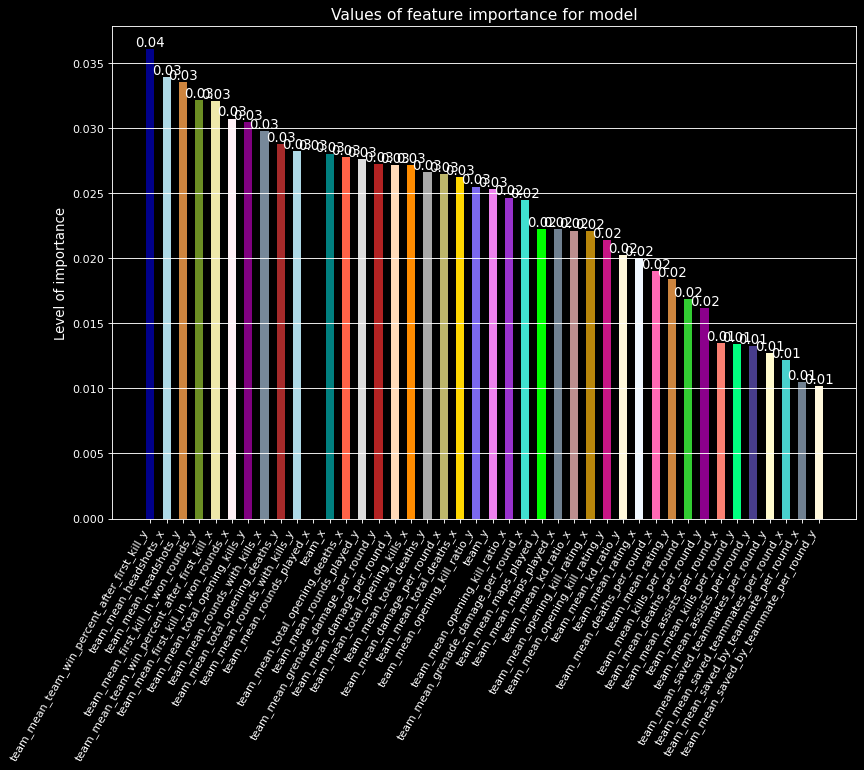

In [56]:
features_forest, best_features_forest = importance_and_auc_roc(RandomForestClassifier)

Model:
 <class 'sklearn.linear_model._logistic.LogisticRegression'>
AUC-ROC value for model from the box:
 0.665
Table of feature importance for algoritm


,feature,importance
0,team_mean_total_opening_deaths_y,0.632117
1,team_mean_total_opening_deaths_x,0.625654
2,team_mean_maps_played_x,0.600827
3,team_mean_maps_played_y,0.600265
4,team_mean_total_deaths_x,0.440939
5,team_mean_total_deaths_y,0.425938
6,team_mean_first_kill_in_won_rounds_x,0.327155
7,team_mean_first_kill_in_won_rounds_y,0.319990
8,team_mean_deaths_per_round_x,0.317501
9,team_mean_headshots_x,0.315230


The most important features (all above the random_feature or in request):



,feature,importance
0,team_mean_total_opening_deaths_y,0.632117
1,team_mean_total_opening_deaths_x,0.625654
2,team_mean_maps_played_x,0.600827
3,team_mean_maps_played_y,0.600265
4,team_mean_total_deaths_x,0.440939
5,team_mean_total_deaths_y,0.425938
6,team_mean_first_kill_in_won_rounds_x,0.327155
7,team_mean_first_kill_in_won_rounds_y,0.319990
8,team_mean_deaths_per_round_x,0.317501
9,team_mean_headshots_x,0.315230


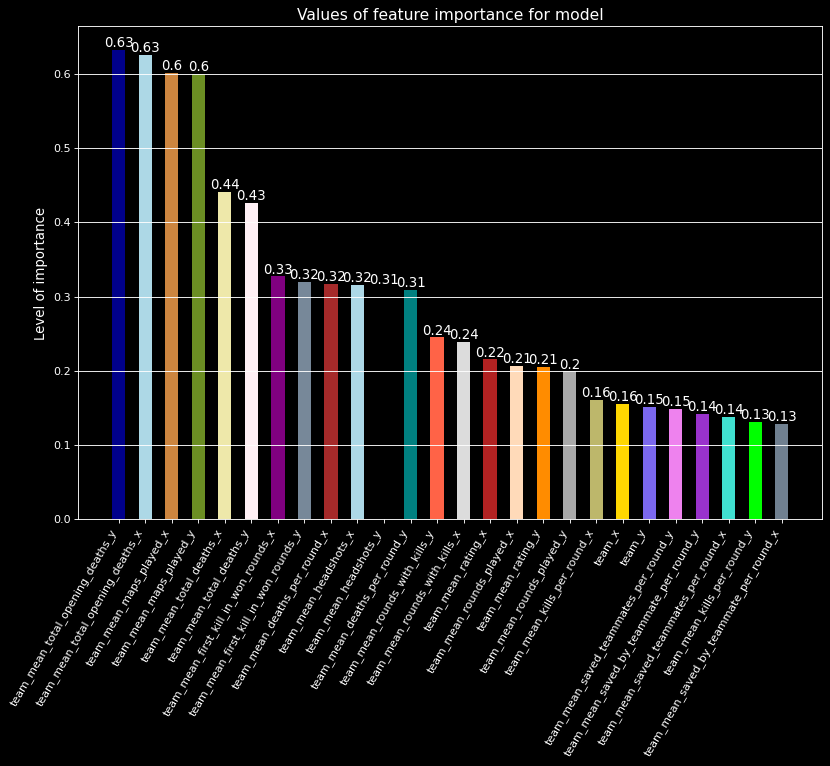

In [57]:
features_lr, best_features_lr = importance_and_auc_roc(LogisticRegression)

Model:
 <class 'lightgbm.sklearn.LGBMClassifier'>
AUC-ROC value for model from the box:
 0.617
Table of feature importance for algoritm


,feature,importance
0,team_mean_headshots_x,139
1,team_mean_headshots_y,138
2,team_mean_first_kill_in_won_rounds_x,130
3,team_mean_team_win_percent_after_first_kill_x,127
4,team_mean_team_win_percent_after_first_kill_y,125
5,team_mean_first_kill_in_won_rounds_y,122
6,team_mean_damage_per_round_x,110
7,team_mean_grenade_damage_per_round_x,106
8,team_mean_grenade_damage_per_round_y,104
9,team_mean_total_opening_kills_x,100


The most important features (all above the random_feature or in request):



,feature,importance
0,team_mean_headshots_x,139
1,team_mean_headshots_y,138
2,team_mean_first_kill_in_won_rounds_x,130
3,team_mean_team_win_percent_after_first_kill_x,127
4,team_mean_team_win_percent_after_first_kill_y,125
5,team_mean_first_kill_in_won_rounds_y,122
6,team_mean_damage_per_round_x,110
7,team_mean_grenade_damage_per_round_x,106
8,team_mean_grenade_damage_per_round_y,104
9,team_mean_total_opening_kills_x,100


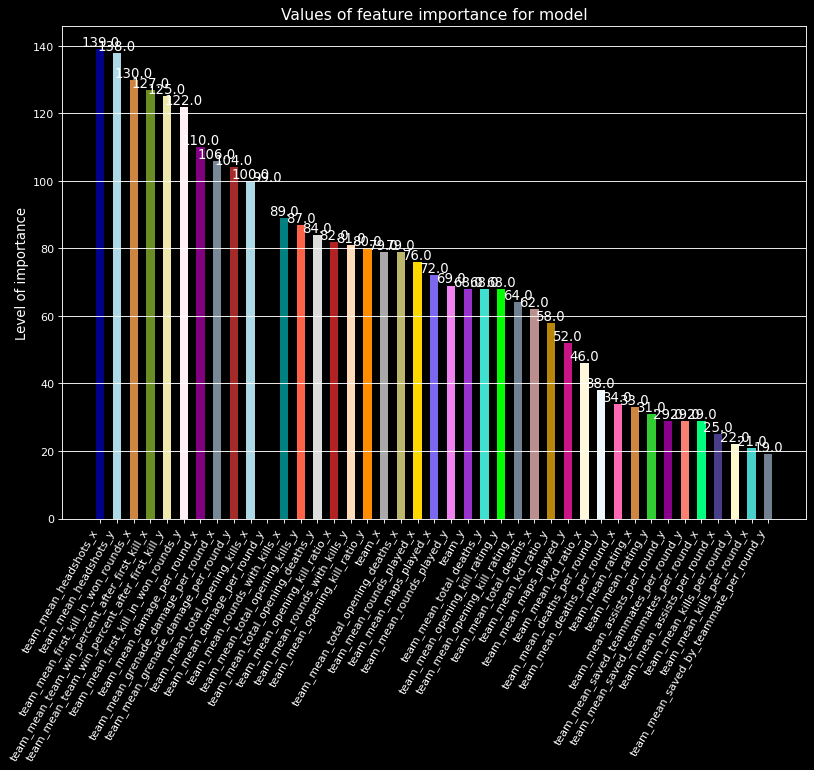

In [58]:
features_lgbmc, best_features_lgbmc = importance_and_auc_roc(LGBMClassifier)

Model:
 <class 'xgboost.sklearn.XGBClassifier'>
AUC-ROC value for model from the box:
 0.598
Table of feature importance for algoritm


,feature,importance
0,team_mean_assists_per_round_x,0.039924
1,team_mean_saved_by_teammate_per_round_y,0.039134
2,team_mean_assists_per_round_y,0.035399
3,team_mean_total_opening_deaths_y,0.029574
4,team_mean_headshots_x,0.029451
5,team_mean_rounds_with_kills_x,0.028920
6,team_mean_rounds_played_x,0.028874
7,team_y,0.028677
8,team_mean_total_opening_kills_y,0.028490
9,team_mean_deaths_per_round_x,0.026475


The most important features (all above the random_feature or in request):



,feature,importance
0,team_mean_assists_per_round_x,0.039924
1,team_mean_saved_by_teammate_per_round_y,0.039134
2,team_mean_assists_per_round_y,0.035399
3,team_mean_total_opening_deaths_y,0.029574
4,team_mean_headshots_x,0.029451
5,team_mean_rounds_with_kills_x,0.028920
6,team_mean_rounds_played_x,0.028874
7,team_y,0.028677
8,team_mean_total_opening_kills_y,0.028490
9,team_mean_deaths_per_round_x,0.026475


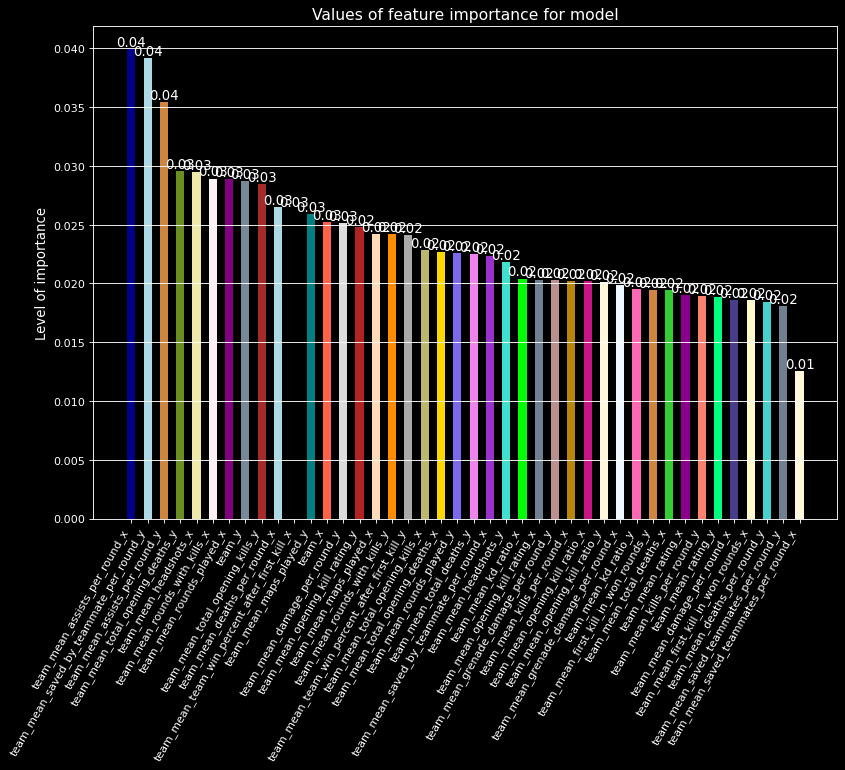

The most important features for the algoritm using included tools


<Figure size 1200x800 with 0 Axes>

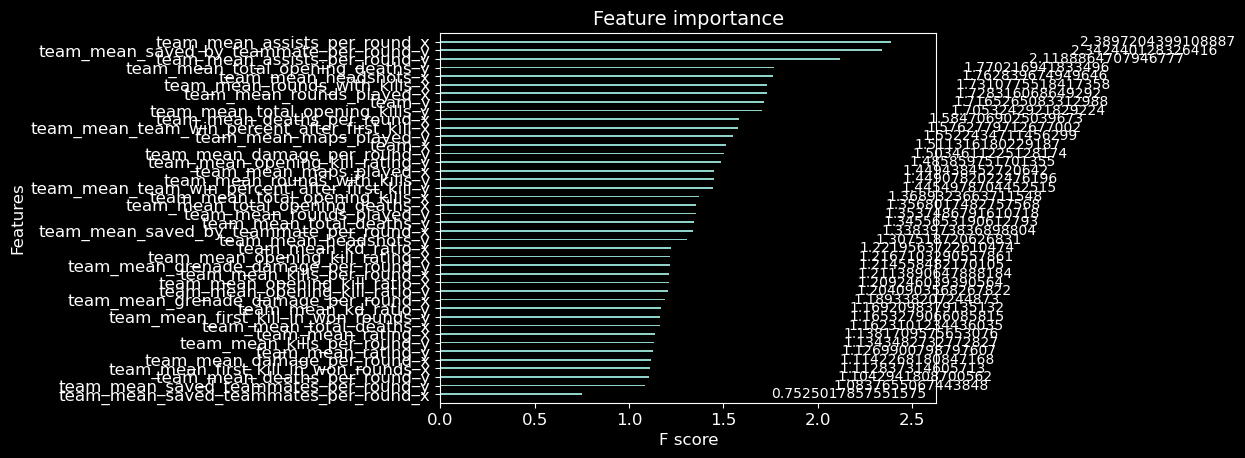

In [59]:
features_xgbc, best_features_xgbc = importance_and_auc_roc(XGBClassifier)

Model:
 <class 'catboost.core.CatBoostClassifier'>
AUC-ROC value for model from the box:
 0.63
Table of feature importance for algoritm


,feature,importance
0,team_mean_headshots_y,5.050740
1,team_mean_headshots_x,4.900653
2,team_mean_first_kill_in_won_rounds_y,4.012387
3,team_mean_team_win_percent_after_first_kill_x,3.808853
4,team_y,3.541483
5,team_mean_first_kill_in_won_rounds_x,3.493610
6,team_mean_team_win_percent_after_first_kill_y,3.344479
7,team_x,3.319347
8,team_mean_total_opening_kills_x,3.161418
9,team_mean_total_opening_deaths_x,3.012653


The most important features (all above the random_feature or in request):



,feature,importance
0,team_mean_headshots_y,5.050740
1,team_mean_headshots_x,4.900653
2,team_mean_first_kill_in_won_rounds_y,4.012387
3,team_mean_team_win_percent_after_first_kill_x,3.808853
4,team_y,3.541483
5,team_mean_first_kill_in_won_rounds_x,3.493610
6,team_mean_team_win_percent_after_first_kill_y,3.344479
7,team_x,3.319347
8,team_mean_total_opening_kills_x,3.161418
9,team_mean_total_opening_deaths_x,3.012653


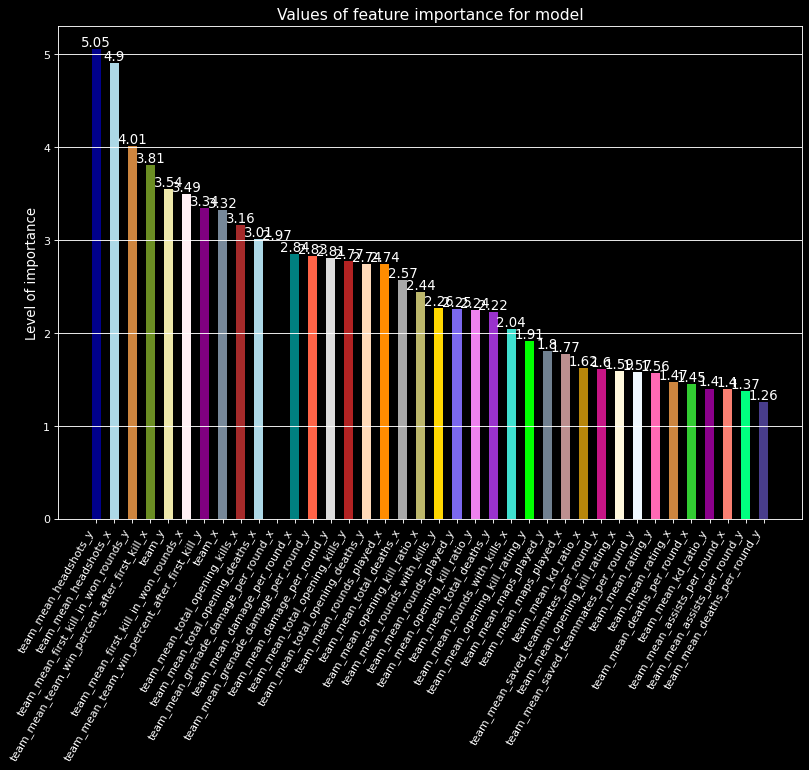

In [60]:
features_catbcl, best_features_catbcl = importance_and_auc_roc(CatBoostClassifier)

## **III. Building models**

The hyperparameter space for searching.

For boosting: less depth, more trees

In [123]:
space_boost = {'eta': hp.uniform('eta', 0.0, 0.3),
               'learning_rate': hp.uniform ('learning_rate', 0, 1),
               'gamma': hp.uniform('gamma', 0.0, 0.5),
               'max_depth': hp.choice ('max_depth', np.arange(2, 50+1, 1, dtype=int)),
               'n_estimators' : hp.choice ('n_estimators', np.arange(1, 200, dtype=int)),
               'min_child_weight': hp.quniform('min_child_weight', 1, 5, 1),
               'subsample': 1, 
               'colsample_bytree': 1,
               'colsample_bylevel': 1,
               'colsample_bynode': 1,
               'lambda': hp.uniform('lambda', 0.0, 1.0),
               'alpha': hp.uniform('alpha', 0.0, 1.0),
               'scale_pos_weight': 1.0,
               'silent': 1,
               'objective': 'binary:logitraw',
               'nthread': 1,
               'eval_metric': 'auc'}

For a random forest: more depth, fewer trees.

In [63]:
space_forest = {'max_depth': hp.choice ('max_depth', np.arange(1, 500+1, dtype=int)),
                'n_estimators' : hp.choice ('n_estimators', np.arange(1, 50, dtype=int)),
                'min_samples_split' : hp.uniform ('min_samples_split', 0, 1)
        }

### 1. The «Random Forest» model

In [64]:
def best_par_hyperopt(features_train, target_train):

    def objective(space_forest):
        
        model_opt = RandomForestClassifier(random_state=random_state, 
                                           max_depth = space_forest['max_depth'], 
                                           n_estimators = space_forest['n_estimators'],
                                           criterion = 'entropy',
                                           min_samples_split = space_forest['min_samples_split'],
                                           class_weight = 'balanced'
                                     )
    
        model_opt.fit(features_train, target_train)
        
        crossval_scores = round(cross_val_score(model_opt, features_train, target_train, scoring='roc_auc', cv=13).mean(), 3)

        return {'loss': -crossval_scores, 'status': STATUS_OK }
    
    trials = Trials()
    best = fmin(fn= objective,
            space= space_forest,
            algo= tpe.suggest,
            max_evals = 100,
            trials= trials,
            show_progressbar=True)
    
    print(best)
    
    # we mark the time for training the best model
    start_time = time.time()
    
    best_model = RandomForestClassifier(random_state=random_state, 
                                        max_depth = best['max_depth'], 
                                        n_estimators = best['n_estimators'],
                                        criterion = 'entropy',
                                        min_samples_split = best['min_samples_split'],
                                        class_weight = 'balanced'
                                       )

    best_model.fit(features_train, target_train)
        
    roc_auc_best = round(cross_val_score(best_model, features_train, target_train, scoring='roc_auc', cv=13).mean(), 2)

    model_time = round((time.time() - start_time), 5)
    
    print(f'The training execution time with the best parameters is {model_time:.3f} sec')

    return best, model_time, roc_auc_best, best_model

In [65]:
best_forest_param, best_forest_time, best_forest_roc_auc, best_forest_model = (
    best_par_hyperopt(features_forest, target))

print('Roc_auc value is', best_forest_roc_auc)

100%|███████████████████| 100/100 [01:21<00:00,  1.22trial/s, best loss: -0.627]
{'max_depth': 461, 'min_samples_split': 0.09823476522224261, 'n_estimators': 31}
The training execution time with the best parameters is 1.204 sec
Roc_auc value is 0.63


### 2. The «Logistic regression» model

In [130]:
model_lr = LogisticRegression(random_state=random_state)

params = {'C': [0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 1, 2, 5, 10, 15, 20],
          'penalty' : ["l1","l2"]}

for i in tqdm(range(len(list(params.get('C'))) * 11)):
    g_cv_lr = GridSearchCV(estimator=model_lr, 
                           param_grid=params, 
                           scoring='roc_auc',
                           cv=13,
                           n_jobs=1,
                           refit=False)
    
    g_cv_lr.fit(features_lr, target)

best_lr_param = g_cv_lr.best_params_


# we mark the time for training the best model
start_time = time.time()
best_g_cv_lr_model = LogisticRegression(random_state=random_state,
                                        solver='lbfgs',
                                        C=g_cv_lr.best_params_.get('C'),
                                        penalty=g_cv_lr.best_params_.get('penalty'),
                                        class_weight = 'balanced').fit(features_lr, target)

best_lr_roc_auc = round(g_cv_lr.best_score_, 2)

best_lr_time = round((time.time() - start_time), 5)

print(best_lr_param)

print(f'The training execution time with the best parameters is {best_lr_time:.3f} sec')
print('Roc_auc value is', best_lr_roc_auc)

  0%|          | 0/132 [00:00<?, ?it/s]

{'C': 0.15, 'penalty': 'l2'}
The training execution time with the best parameters is 0.023 sec
Roc_auc value is 0.68


### 3. The LightGBM model

In [118]:
def best_par_hyperopt(features_train, target_train):

    def objective(space_boost):

        model_opt = LGBMClassifier(random_state=random_state, 
                                   n_estimators = space_boost['n_estimators'],
                                   learning_rate = space_boost['learning_rate']
                                  )

        model_opt.fit(features_train, target_train, verbose=0)

        crossval_scores = round(cross_val_score(model_opt, features_train, target_train, scoring='roc_auc', cv=13).mean(), 3)

        return {'loss': -crossval_scores, 'status': STATUS_OK }

    trials = Trials()
    best = fmin(fn= objective,
            space= space_boost,
            algo= tpe.suggest,
            max_evals = 100,
            trials= trials,
            show_progressbar=True)

    print(best)

    # we mark the time for training the best model
    start_time = time.time()

    best_model = LGBMClassifier(random_state=random_state, 
                                n_estimators = best['n_estimators'],
                                learning_rate = best['learning_rate']
                               )

    best_model.fit(features_train, target_train, verbose=0)

    roc_auc_best = round(cross_val_score(best_model, features_train, target_train, scoring='roc_auc', cv=13).mean(), 2)

    model_time = round((time.time() - start_time), 5)

    print(f'The training execution time with the best parameters is {model_time:.3f} sec')

    return best, model_time, roc_auc_best, best_model

In [119]:
best_lgbmc_param, best_lgbmc_time, best_lgbmc_roc_auc, best_lgbmc_model = (
    best_par_hyperopt(features_lgbmc, target))

print('Roc_auc value', best_lgbmc_roc_auc)

100%|███████████████████| 100/100 [31:47<00:00, 19.08s/trial, best loss: -0.632]
{'alpha': 0.22486480476083848, 'eta': 0.15891828354678442, 'gamma': 0.08965368873198909, 'lambda': 0.1044467803059107, 'learning_rate': 0.03022637401143169, 'max_depth': 48, 'min_child_weight': 5.0, 'n_estimators': 126}
The training execution time with the best parameters is 25.365 sec
Roc_auc value 0.63


### 4. The XGBoost model

In [125]:
def best_par_hyperopt(features_train, target_train):

    def objective(space_boost):
        
        model_opt = XGBClassifier(random_state=random_state, 
                                      n_estimators = space_boost['n_estimators'],
                                     )
    
        model_opt.fit(features_train, target_train)
        
        crossval_scores = round(cross_val_score(model_opt, features_train, target_train, scoring='roc_auc', cv=13).mean(), 3)

        return {'loss': -crossval_scores, 'status': STATUS_OK }
    
    trials = Trials()
    best = fmin(fn= objective,
            space= space_boost,
            algo= tpe.suggest,
            max_evals = 50,
            trials= trials,
            show_progressbar=True)
    
    print(best)

    # we mark the time for training the best model
    start_time = time.time()
    
    best_model = XGBClassifier(random_state=random_state, 
                                   n_estimators = best['n_estimators']
                                  )
    
    best_model.fit(features_train, target_train)
    

    
    roc_auc_best = round(cross_val_score(best_model, features_train, target_train, scoring='roc_auc', cv=13).mean(), 2)

    model_time = round((time.time() - start_time), 5)
    
    print(f'The training execution time with the best parameters is {model_time:.3f} sec')

    return best, model_time, roc_auc_best, best_model

In [126]:
best_xgbc_param, best_xgbc_time, best_xgbc_roc_auc, best_xgbc_model = (
    best_par_hyperopt(features_xgbc, target))

print('Roc_auc value is', best_xgbc_roc_auc)

100%|█████████████████████| 50/50 [06:45<00:00,  8.11s/trial, best loss: -0.607]
{'alpha': 0.19992982537514326, 'eta': 0.03555829024359669, 'gamma': 0.14144922981984115, 'lambda': 0.1317709451234823, 'learning_rate': 0.9257371323888253, 'max_depth': 26, 'min_child_weight': 5.0, 'n_estimators': 147}
The training execution time with the best parameters is 10.758 sec
Roc_auc value is 0.61


### Interim result

We received the following data on the best models in training

In [131]:
# add all models to the dictionary for quick access to the name and the model itself
models = {'RandomForest' : best_forest_model,
          'LogisticRegression' : best_g_cv_lr_model,
          'LGBMClassifier' : best_lgbmc_model,
          'XGBClassifier' : best_xgbc_model 
         }

models_description = [
    ['RandomForest',best_forest_roc_auc, best_forest_time, best_forest_param],
    ['LogisticRegression', best_lr_roc_auc, best_lr_time, best_lr_param],
    ['LGBMClassifier', best_lgbmc_roc_auc, best_lgbmc_time, best_lgbmc_param],
    ['XGBClassifier', best_xgbc_roc_auc, best_xgbc_time, best_xgbc_param]
]

models_features = {
    'RandomForest' : features_forest,
    'LogisticRegression' : features_lr,
    'LGBMClassifier' : features_lgbmc,
    'XGBClassifier' : features_xgbc
}

columns_models_description = ['Model', 'Best roc_auc value due to train', 
                              'Execution time of the optimal parameter, sec.', 'The best hyperparameters']

models_summary = pd.DataFrame(data=models_description, columns=columns_models_description)
pd.set_option('display.max_colwidth', None)
models_summary.sort_values(by='Best roc_auc value due to train', ascending=False)

,Model,Best roc_auc value due to train,"Execution time of the optimal parameter, sec.",The best hyperparameters
1,LogisticRegression,0.68,0.02282,"{'C': 0.15, 'penalty': 'l2'}"
0,RandomForest,0.63,1.20427,"{'max_depth': 461, 'min_samples_split': 0.09823476522224261, 'n_estimators': 31}"
2,LGBMClassifier,0.63,25.36542,"{'alpha': 0.22486480476083848, 'eta': 0.15891828354678442, 'gamma': 0.08965368873198909, 'lambda': 0.1044467803059107, 'learning_rate': 0.03022637401143169, 'max_depth': 48, 'min_child_weight': 5.0, 'n_estimators': 126}"
3,XGBClassifier,0.61,10.75827,"{'alpha': 0.19992982537514326, 'eta': 0.03555829024359669, 'gamma': 0.14144922981984115, 'lambda': 0.1317709451234823, 'learning_rate': 0.9257371323888253, 'max_depth': 26, 'min_child_weight': 5.0, 'n_estimators': 147}"


### **5. Checking the best model on a test sample**

Let's write a function to output basic information on the selected best model and predictions on test sample

In [153]:
def model_chose(name, write='no'):
    best_model_name = str(name)
    
    best_model = models.get(best_model_name)
    best_model_features = models_features.get(best_model_name)
    best_model_summary = models_summary[models_summary['Model'] == best_model_name]
    
    print('\033[4m\033[1m\033[31m{}\033[0m'.format('Chosen model description'))
    display(best_model_summary)
    print()
    prediction = best_model.predict(best_model_features)
    report = classification_report(target, prediction)
    print('\033[4m\033[1m\033[31m{}\033[0m'.format('Classification report'))
    print(report)
    
    # prediction block
    prediction_test = best_model.predict(test[best_model_features.columns])
    test_for_output = pd.read_csv('~/Desktop/Py_projects/GitHub/Test_tasks/Win_predict_cs/datasets/test.csv', 
                                  index_col = 'index').reset_index(drop = True)
    test_for_output['who_win'] = prediction_test

    # write block    
    if write == 'yes':
        print('Please input file name for saving results on your laptop', end='')
        file_name = str(input()).lower()
        test_for_output.to_csv(f'{file_name}.csv', index=False)
    
    # output block
    print('Do you want to see the result sample?', end='')
    answer = str(input()).lower()
    if answer in ['yes', 'y', '1']:
        display(test_for_output)

In [154]:
model_chose('LogisticRegression', 'yes')

Chosen model description


,Model,Best roc_auc value due to train,"Execution time of the optimal parameter, sec.",The best hyperparameters
1,LogisticRegression,0.68,0.02282,"{'C': 0.15, 'penalty': 'l2'}"



Classification report
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       697
           1       0.64      0.64      0.64       697

    accuracy                           0.64      1394
   macro avg       0.64      0.64      0.64      1394
weighted avg       0.64      0.64      0.64      1394

Please input file name for saving results on your laptop

 logreg


Do you want to see the result sample?

 n


In [155]:
model_chose('RandomForest', 'yes')

Chosen model description


,Model,Best roc_auc value due to train,"Execution time of the optimal parameter, sec.",The best hyperparameters
0,RandomForest,0.63,1.20427,"{'max_depth': 461, 'min_samples_split': 0.09823476522224261, 'n_estimators': 31}"



Classification report
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       697
           1       0.74      0.77      0.75       697

    accuracy                           0.75      1394
   macro avg       0.75      0.75      0.75      1394
weighted avg       0.75      0.75      0.75      1394

Please input file name for saving results on your laptop

 forest


Do you want to see the result sample?

 n


In [157]:
model_chose('LGBMClassifier', 'yes')

Chosen model description


,Model,Best roc_auc value due to train,"Execution time of the optimal parameter, sec.",The best hyperparameters
2,LGBMClassifier,0.63,25.36542,"{'alpha': 0.22486480476083848, 'eta': 0.15891828354678442, 'gamma': 0.08965368873198909, 'lambda': 0.1044467803059107, 'learning_rate': 0.03022637401143169, 'max_depth': 48, 'min_child_weight': 5.0, 'n_estimators': 126}"



Classification report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       697
           1       0.99      0.98      0.98       697

    accuracy                           0.98      1394
   macro avg       0.98      0.98      0.98      1394
weighted avg       0.98      0.98      0.98      1394

Please input file name for saving results on your laptop

 lgbm


Do you want to see the result sample?

 n


## **IV. Results of the research**

<font color=#008B8B> **During the analysis, preprocessing and research of the provided data, the following conclusions were made:** </font>

- omissions and duplicates have been processed;
- features were selected for machine learning model training;
- data was generated to analyze the statistics of individual players; when adding a time feature about the date of the match, we can try to improve the prediction model by solving time series predicting the expected performance of individual players.

---

<font color=#DC143C> **Created models:** </font>
- we have created several types of winner prediction models and selected the best parameters with a high auc-roc metric
- we also uploaded three files with predictions based on different models for verification.